# Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import plotly.express as px
import missingno as msno
from matplotlib.ticker import FuncFormatter

# Load Data

In [4]:
train_ori = pd.read_json('../datasets/train.json') # Want to recreate dummy as I don't want to drop

In [5]:
train_df = pd.read_csv('../datasets/train_clean.csv')

In [6]:
dummy_station_columns = [col for col in train_df.columns if col.startswith('station_name_')]
train_df = train_df.drop(dummy_station_columns, axis=1)

In [7]:
train_df.shape

(14103, 25)

In [8]:
train_ori.columns

Index(['id', 'province', 'district', 'subdistrict', 'address', 'property_type',
       'total_units', 'bedrooms', 'baths', 'floor_area', 'floor_level',
       'land_area', 'latitude', 'longitude', 'nearby_stations',
       'nearby_station_distance', 'nearby_bus_stops', 'nearby_supermarkets',
       'nearby_shops', 'year_built', 'month_built', 'facilities', 'price'],
      dtype='object')

In [9]:
train_df['nearby_station_distance'] = train_ori['nearby_station_distance']

In [10]:
# Redummy again
dummy_station = pd.get_dummies(
    train_df['nearby_station_distance'].explode().apply(lambda x: pd.Series(x))[0],
).groupby(level=0).sum()

# Join the dummy variables back to train_clean
train_df= train_df.join(dummy_station)

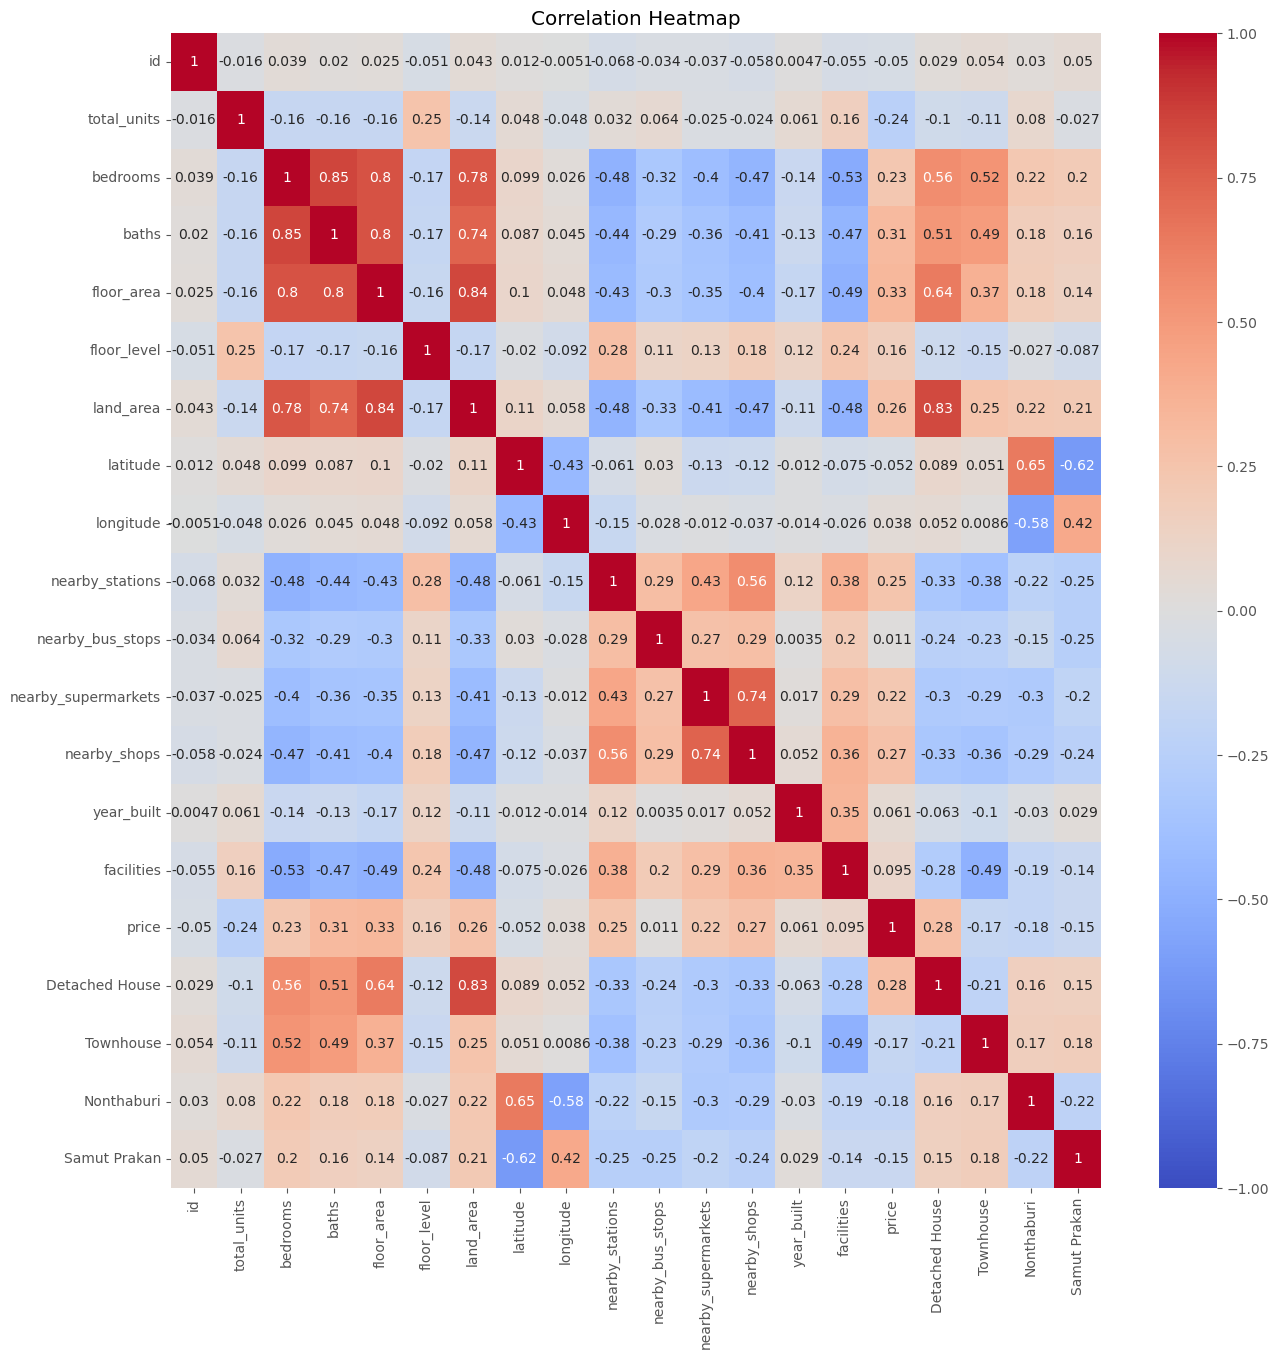

In [11]:
# Find correlation
# Drop the 'dummy_station' column and calculate the correlation matrix
correlation_matrix = train_df.drop(columns=dummy_station).corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(15, 15))

# Draw the heatmap
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

# Display the heatmap
plt.title('Correlation Heatmap')
plt.show()

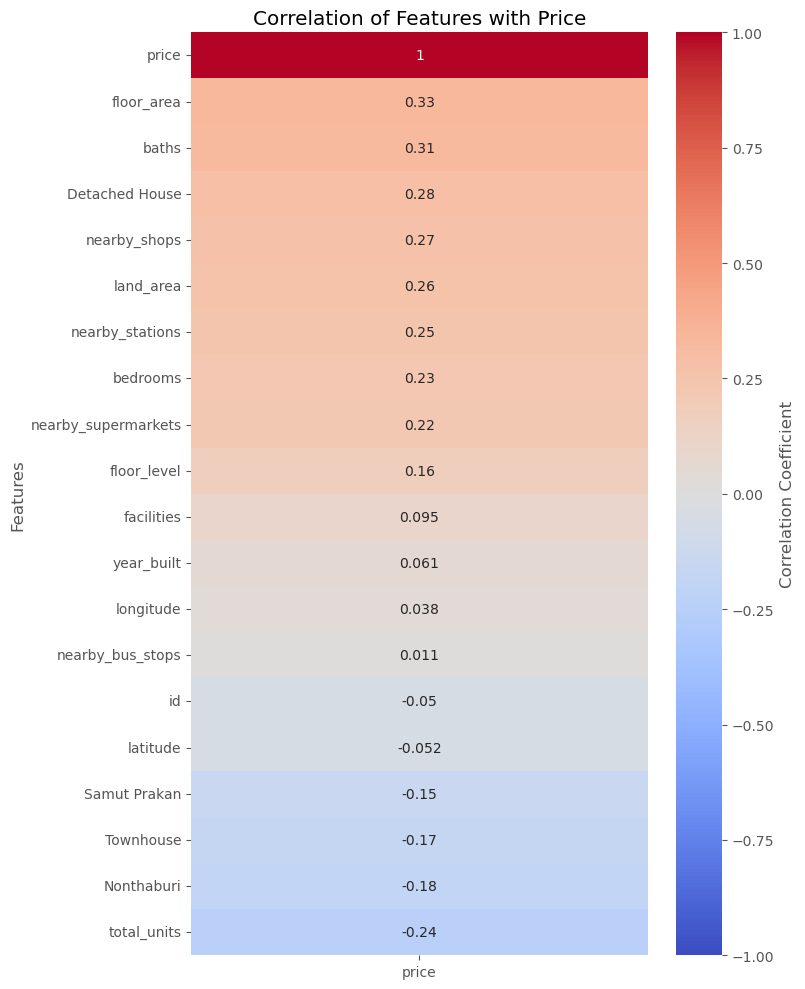

In [12]:
# Create a correlation matrix while excluding specified columns
corr_matrix = train_df.drop(columns=dummy_station, errors='ignore').corr(numeric_only=True)

# Focus on the correlation with 'price'
price_corr = corr_matrix[['price']].sort_values(by='price', ascending=False)

# Plot the heatmap focusing on correlation with price
plt.figure(figsize=(8, 10))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation of Features with Price')
plt.ylabel('Features')

plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

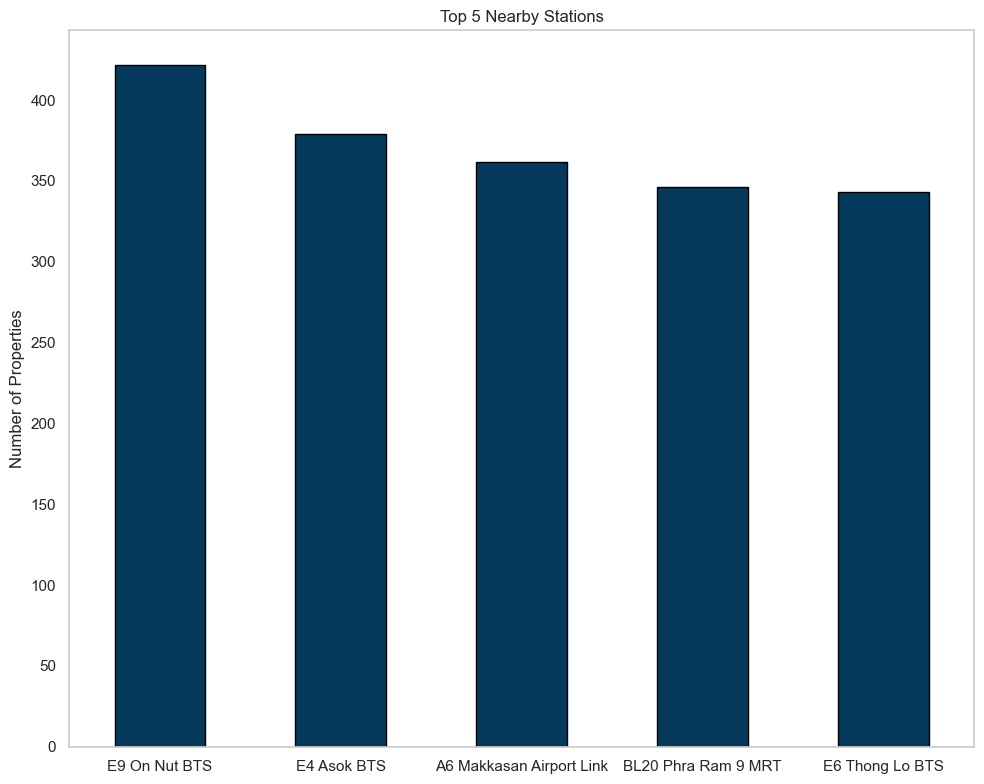

In [43]:
# Sum the counts of each station to find the top 5
top_5_station = dummy_station.sum().sort_values(ascending=False).head(5)

# Plot
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))

# Plotting with custom bar color
top_5_station.plot(kind='bar', color='#04395b', edgecolor='black')

# Titles and labels
plt.title("Top 5 Nearby Stations")
plt.ylabel("Number of Properties")
plt.xticks(rotation=0)
plt.grid(False)  # Disable grid
plt.tight_layout()  # Adjust layout for spacing

plt.savefig('../images/top_5_nearby_stations.png', format='png', dpi=1200)

plt.show()


In [14]:
top_5_station = dummy_station.sum().sort_values(ascending=False).head(5)
top_5_station

E9 On Nut BTS               422
E4 Asok BTS                 379
A6 Makkasan Airport Link    362
BL20 Phra Ram 9 MRT         346
E6 Thong Lo BTS             343
dtype: int64

In [15]:
# Define top stations
top_stations = ['E9 On Nut BTS', 'E4 Asok BTS', 'A6 Makkasan Airport Link',
                'E6 Thong Lo BTS', 'BL20 Phra Ram 9 MRT']

# Select relevant columns including the price
size_layout_data = train_df[top_stations + ['floor_area', 'bedrooms', 'baths', 'property_type', 'price']]

# Filter properties with proximity to at least one of the top stations
size_layout_data = size_layout_data[size_layout_data[top_stations].sum(axis=1) > 0]

# Identify the closest station for each property and create a new column for it
size_layout_data['closest_station'] = size_layout_data[top_stations].idxmax(axis=1)

# Calculate average floor_area, bedrooms, baths, and price grouped by closest station and property type
size_layout_summary = size_layout_data.groupby(['closest_station', 'property_type']).mean()

# Select relevant summary statistics including price
summary = size_layout_summary[['floor_area', 'bedrooms', 'baths', 'price']]

# Print the summary
print(summary)

                                         floor_area  bedrooms     baths  \
closest_station          property_type                                    
A6 Makkasan Airport Link Condo            33.800000  1.000000  1.000000   
                         Detached House  215.000000  3.500000  2.500000   
                         Townhouse       110.444444  2.555556  2.222222   
BL20 Phra Ram 9 MRT      Condo            42.878788  1.202020  1.151515   
                         Detached House  195.900000  3.200000  2.500000   
                         Townhouse       145.107143  2.857143  2.607143   
E4 Asok BTS              Condo            39.421488  1.190083  1.128099   
                         Detached House  190.287879  3.454545  2.712121   
                         Townhouse       123.492958  3.084507  2.352113   
E6 Thong Lo BTS          Condo            41.405286  1.198238  1.132159   
                         Detached House  192.881356  3.423729  2.847458   
                         

In [16]:
# Define top stations
top_stations = ['E9 On Nut BTS', 'E4 Asok BTS', 'A6 Makkasan Airport Link',
                'E6 Thong Lo BTS', 'BL20 Phra Ram 9 MRT']

# Select relevant columns including the price
top_station_data = train_df[top_stations + ['price']]

# Filter properties with proximity to at least one of the top stations
top_station_data = top_station_data[top_station_data[top_stations].sum(axis=1) > 0]

# Identify the closest station for each property and create a new column for it
top_station_data['closest_station'] = top_station_data[top_stations].idxmax(axis=1)

# Calculate average price grouped by closest station
top_station_summary = top_station_data.groupby('closest_station')['price'].mean().reset_index()

# Format the price column for better readability
top_station_summary['price'] = top_station_summary['price'].map(lambda x: f"{x:,.0f} THB")

# Print the formatted summary
print(top_station_summary)


            closest_station          price
0  A6 Makkasan Airport Link  3,208,438 THB
1       BL20 Phra Ram 9 MRT  3,939,624 THB
2               E4 Asok BTS  4,203,201 THB
3           E6 Thong Lo BTS  4,110,663 THB
4             E9 On Nut BTS  3,921,666 THB


In [17]:
# Calculate the correlation coefficient
correlation = train_df['nearby_stations'].corr(train_df['price'])
print(f"Correlation between nearby station and price: {correlation:.2f}")

Correlation between nearby station and price: 0.25


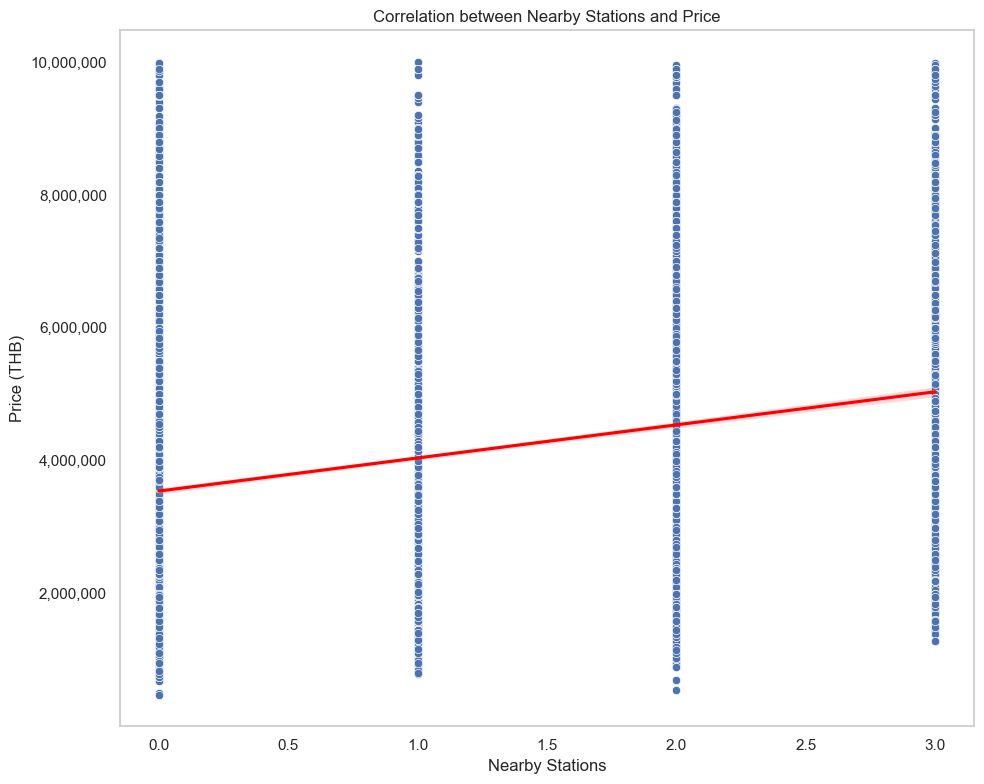

Positive Correlation: The positive sign suggests that as the number of nearby stations increases, the price tends to increase.


In [41]:
# Plot Correlation between Nearby Stations and Price
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot the correlation between the nearby stations and the price
sns.scatterplot(data=train_df, x='nearby_stations', y='price', marker='o')  
sns.regplot(data=train_df, x='nearby_stations', y='price', scatter=False,color='red')  # Default color for regression line

# Add title and labels
plt.title('Correlation between Nearby Stations and Price')
plt.xlabel('Nearby Stations')
plt.ylabel('Price (THB)')

# Format y-axis for better readability
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.grid(False)
plt.tight_layout()

plt.savefig('../images/nearby_station_corr.png', format='png', dpi=1200)

plt.show()

# Calculate and interpret the correlation coefficient
correlation = train_df['nearby_stations'].corr(train_df['price'])
if correlation < 0:
    correlation_type = "Negative Correlation: The negative sign suggests that as the number of nearby stations increases, the price tends to decrease."
else:
    correlation_type = "Positive Correlation: The positive sign suggests that as the number of nearby stations increases, the price tends to increase."

print(correlation_type)

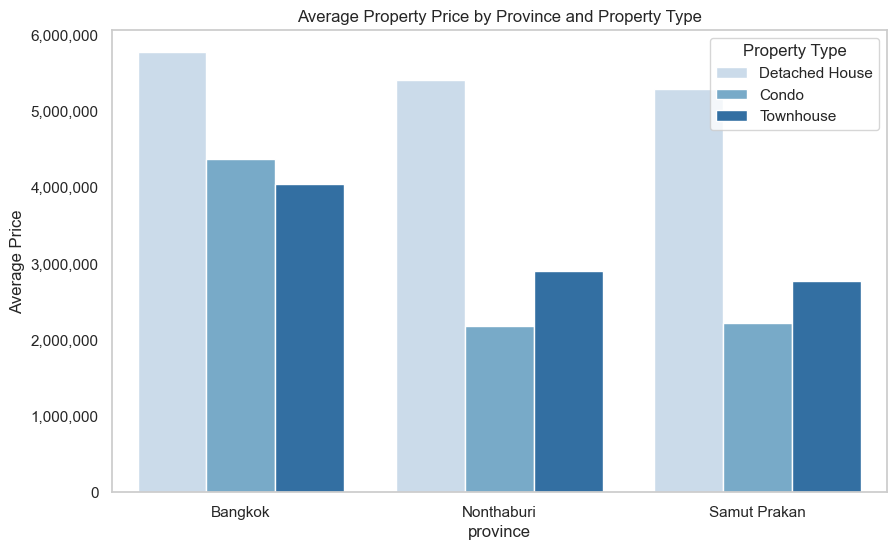

In [21]:
# Plot Average Property Price by Province and Property Type
# Set the style for the plot
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='province', 
    y='price', 
    hue='property_type', 
    data=train_df.groupby(['province', 'property_type'])['price'].mean().reset_index().sort_values(by='price', ascending=False),
    palette='Blues')  # Applying the blues color palette
plt.title('Average Property Price by Province and Property Type')
plt.ylabel('Average Price')
plt.xticks(rotation=0)


plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}')) # Format y-axis with commas for readability

# Optional: Remove grid and add legend title
plt.grid(False)
plt.legend(title='Property Type')
plt.savefig('../images/average_property_by_property_type.png', format='png', dpi=300)
plt.show()


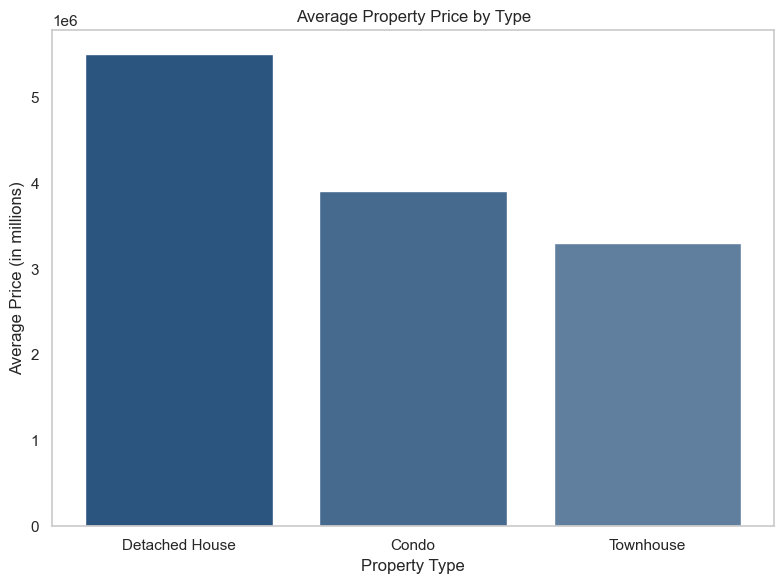

In [25]:
# Calculate average price by property type
average_price = train_df.groupby('property_type')['price'].mean().reset_index().sort_values(by='price', ascending=False)

# Plotting
sns.set(style="whitegrid")

palette = ['#2B547E', '#46698E', '#607F9E'] # Define the color palette

# Plotting
plt.figure(figsize=(8,6 ))
bars = plt.bar(average_price['property_type'], average_price['price'], color=palette)
plt.title('Average Property Price by Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price (in millions)')
plt.xticks(rotation=0)
plt.grid(False)
plt.tight_layout()  

plt.savefig('../images/average_property_type.png', format='png', dpi=300)
plt.show()